In [2]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import timedelta

In [3]:
model = joblib.load('xgboost_demand_model.pkl')
model2 = joblib.load('random_forest_ride_hailing_model.pkl')

In [4]:
df = pd.read_csv("dataset/cleaned_2016_tripdata.csv", parse_dates=['tpep_pickup_datetime'])

In [14]:
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day'] = df['tpep_pickup_datetime'].dt.day
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['month'] = df['tpep_pickup_datetime'].dt.month
df['location'] = df['location'].astype('category')
df['location_encoded'] = df['location'].cat.codes
location_categories = df['location'].cat.categories

KeyboardInterrupt: 

In [ ]:
df['datetime'] = df['tpep_pickup_datetime'].dt.floor('h')
grouped = df.groupby(['datetime', 'cluster', 'location_encoded']).size().reset_index(name='trip_count')
grouped = grouped.sort_values('datetime')

In [ ]:
future_dates = pd.date_range(start='2016-04-01 00:00:00', end='2016-04-30 23:00:00', freq='h')

In [ ]:
cluster_locs = grouped[['cluster', 'location_encoded']].drop_duplicates()

In [ ]:
future_predictions = []

for _, row in cluster_locs.iterrows():
    c = row['cluster']
    l = row['location_encoded']
    
    history = grouped[(grouped['cluster'] == c) & (grouped['location_encoded'] == l)].copy()
    history = history.set_index('datetime').asfreq('h').fillna(0)

    
    for dt in future_dates:
        lag_1 = history['trip_count'].shift(1).loc[dt - timedelta(hours=1)] if dt - timedelta(hours=1) in history.index else 0
        lag_24 = history['trip_count'].shift(24).loc[dt - timedelta(hours=24)] if dt - timedelta(hours=24) in history.index else 0
        lag_168 = history['trip_count'].shift(168).loc[dt - timedelta(hours=168)] if dt - timedelta(hours=168) in history.index else 0
        rolling_mean_24 = history['trip_count'].shift(1).rolling(window=24).mean().loc[dt - timedelta(hours=1)] if dt - timedelta(hours=1) in history.index else 0

        features = pd.DataFrame({
            'hour': [dt.hour],
            'day': [dt.day],
            'weekday': [dt.weekday()],
            'month': [dt.month],
            'cluster': [c],
            'location_encoded': [l],
            'lag_1': [lag_1],
            'lag_24': [lag_24],
            'lag_168': [lag_168],
            'rolling_mean_24': [rolling_mean_24],
        })

        pred = model.predict(features)[0]

        history.loc[dt] = pred
        
        future_predictions.append({
            'datetime': dt,
            'cluster': c,
            'location_encoded': l,
            'trip_count': pred
        })

In [ ]:
cluster_location_map = {
    0: "Padua Friary, 151, Thompson Street, University Village, Manhattan, New York County, New York, 10012, United States",
    1: "Queens, Queens County, New York, 11430, United States",
    2: "211, East 81st Street, Upper East Side, Manhattan Community Board 8, Manhattan, New York County, New York, 10028, United States",
    3: "225, West 36th Street, Garment District, Manhattan Community Board 5, Manhattan, New York County, New York, 10018, United States",
    4: "Grand Central Parkway, Queens, Queens County, New York, 11371, United States",
    5: "Turtle Bay, Manhattan Community Board 6, Manhattan, New York County, New York, 10152, United States",
    6: "Public School 163, 163, West 97th Street, Manhattan Valley, Manhattan Community Board 7, Manhattan, New York County, New York, 10025, United States",
    7: "Aro, 242, West 53rd Street, Clinton, Manhattan Community Board 5, Manhattan, New York County, New York, 10019, United States",
    8: "289, Adelphi Street, Fort Greene, Brooklyn, Kings County, New York, 11205, United States",
    9: "Millennium, 55, Church Street, Tribeca, Manhattan, New York County, New York, 10007, United States",
    10: "160, West 74th Street, Upper West Side, Manhattan Community Board 7, Manhattan, New York County, New York, 10023, United States",
    11: "2239, Adam Clayton Powell Jr. Boulevard, Manhattan Community Board 10, Manhattan, New York County, New York, 10027, United States",
    12: "69th Regiment Armory, 68, Lexington Avenue, Rose Hill, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States",
    13: "36-50, 38th Street, Sunnyside Gardens, Queens, Queens County, New York, 11101, United States",
    14: "149, 8th Avenue, Chelsea, Manhattan Community Board 4, Manhattan, New York County, New York, 10011, United States",
    15: "81, 1st Avenue, East Village, Manhattan Community Board 3, Manhattan, New York County, New York, 10003, United States",
}

In [ ]:
future_df = pd.DataFrame(future_predictions)
future_df["trip_count"] = future_df["trip_count"].round().astype(int)
future_df["location"] = future_df['location_encoded'].apply(lambda x: location_categories[x])
future_df.to_csv('XGBoost_april_2016_ride_demand_predictions.csv', index=False)

In [ ]:
future_predictions2 = []

for _, row in cluster_locs.iterrows():
    c = row['cluster']
    l = row['location_encoded']
    
    history = grouped[(grouped['cluster'] == c) & (grouped['location_encoded'] == l)].copy()
    history = history.set_index('datetime').asfreq('h').fillna(0)

    
    for dt in future_dates:
        lag_1 = history['trip_count'].shift(1).loc[dt - timedelta(hours=1)] if dt - timedelta(hours=1) in history.index else 0
        lag_24 = history['trip_count'].shift(24).loc[dt - timedelta(hours=24)] if dt - timedelta(hours=24) in history.index else 0
        lag_168 = history['trip_count'].shift(168).loc[dt - timedelta(hours=168)] if dt - timedelta(hours=168) in history.index else 0
        rolling_mean_24 = history['trip_count'].shift(1).rolling(window=24).mean().loc[dt - timedelta(hours=1)] if dt - timedelta(hours=1) in history.index else 0

        features = pd.DataFrame({
            'hour': [dt.hour],
            'day': [dt.day],
            'weekday': [dt.weekday()],
            'month': [dt.month],
            'cluster': [c],
            'location_encoded': [l],
            'lag_1': [lag_1],
            'lag_24': [lag_24],
            'lag_168': [lag_168],
            'rolling_mean_24': [rolling_mean_24],
        })

        pred = model2.predict(features)[0]

        history.loc[dt] = pred
        
        future_predictions2.append({
            'datetime': dt,
            'cluster': c,
            'location_encoded': l,
            'trip_count': pred
        })

KeyboardInterrupt: 

In [ ]:
future_df2 = pd.DataFrame(future_predictions2)
future_df2["trip_count"] = future_df2["trip_count"].round().astype(int)
future_df2["location"] = future_df2['location_encoded'].apply(lambda x: location_categories[x])
future_df2.to_csv('RandomForest_april_2016_ride_demand_predictions.csv', index=False)

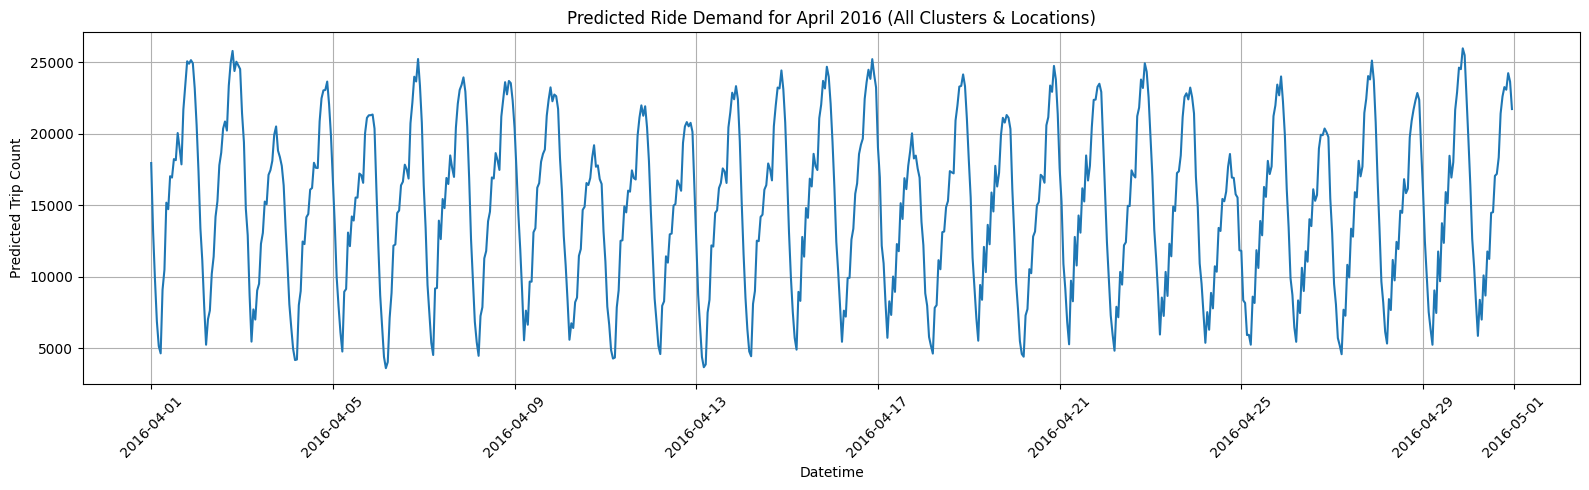

In [ ]:
df_plot = future_df.groupby('datetime')['trip_count'].sum().reset_index()
plt.figure(figsize=(16,5))
plt.plot(df_plot['datetime'], df_plot['trip_count'])
plt.title('Predicted Ride Demand for April 2016 (All Clusters & Locations)')
plt.xlabel('Datetime')
plt.ylabel('Predicted Trip Count')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

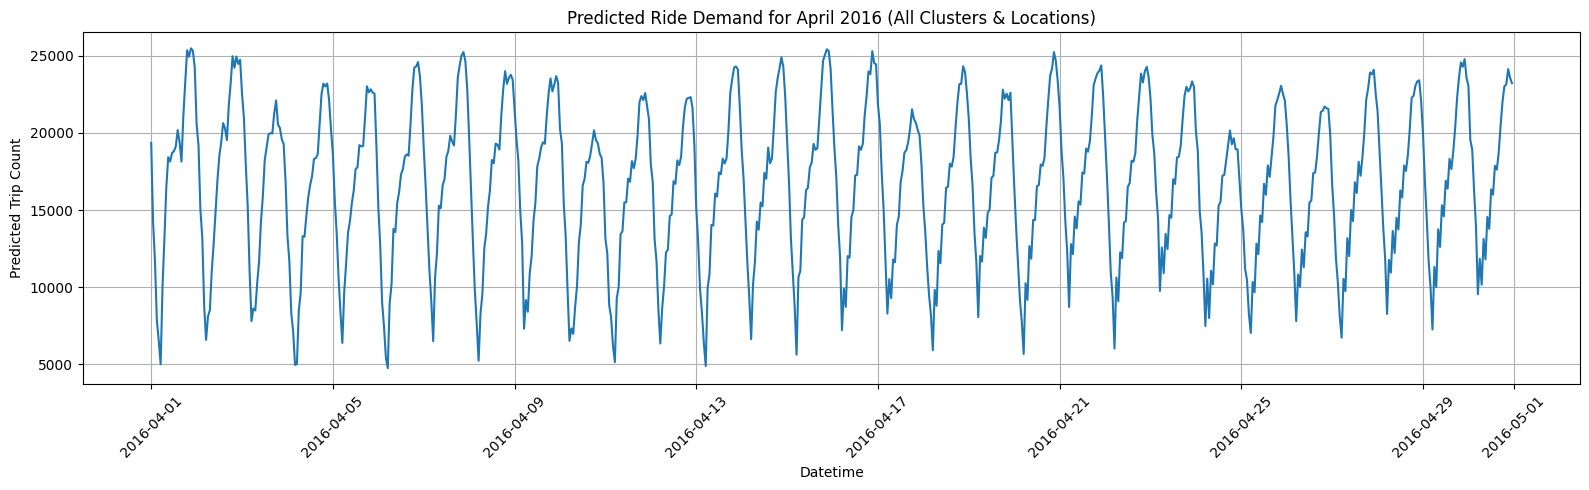

In [ ]:
df_plot = future_df2.groupby('datetime')['trip_count'].sum().reset_index()
plt.figure(figsize=(16,5))
plt.plot(df_plot['datetime'], df_plot['trip_count'])
plt.title('Predicted Ride Demand for April 2016 (All Clusters & Locations)')
plt.xlabel('Datetime')
plt.ylabel('Predicted Trip Count')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()